# Precipitation Forecasting using VARMA

In this notebook, we investigate VARMA (Vector autoregressive moving average process) as a model to forecast precipitation.

## 0. Imports and Basic Setup

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from multiprocessing import Process, Manager
import warnings

warnings.filterwarnings("ignore")

## 1. Load Preprocessed Train, Validation, and Test Splits


In [2]:
train_data = pd.read_csv("../data/processed/train_data.csv")
validation_data = pd.read_csv("../data/processed/validation_data.csv")
test_data = pd.read_csv("../data/processed/test_data.csv")

# Sort splits by location -> YYYY -> DOY to ensure correct time ordering
train_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
validation_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
test_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)

## 2. Create Sequences for XGBoost


In [3]:
def create_sequences(df, feature_cols, target_col, seq_length=30):
    """
    For each location independently, create sequences of length seq_length
    to predict the (seq_length+1)-th day's target_col.
    Returns:
        X: np.array of shape (num_samples, seq_length, num_features)
        y: np.array of shape (num_samples,)
    """
    X_list, y_list = [], []

    # Group by location so we don't mix data across different basins
    grouped = df.groupby("location", group_keys=True)

    for loc, loc_df in grouped:
        loc_df = loc_df.reset_index(drop=True)  # reindex after grouping

        # Convert to numpy for slicing
        loc_features = loc_df[feature_cols].values
        loc_target = loc_df[target_col].values

        # Slide over the time dimension for that location
        for i in range(len(loc_df) - seq_length):
            X_list.append(loc_features[i : i + seq_length])
            y_list.append(loc_target[i + seq_length])

    X_arr = np.array(X_list)
    y_arr = np.array(y_list)
    return X_arr, y_arr

## 3. Define Features and Target


In [4]:
exclude_cols = ["location", "YYYY", "DOY", "MM", "DD"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]
target_col = "prec"

print("Feature columns:", feature_cols)
print("Target column:", target_col)

Feature columns: ['2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe', 'surf_net_solar_rad_max', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press', 'total_et', 'prec', 'volsw_123', 'volsw_4']
Target column: prec


## 4. Generate sequences

In [5]:
SEQ_LENGTH = 30
X_train, y_train = create_sequences(train_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_val, y_val = create_sequences(validation_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, feature_cols, target_col, seq_length=SEQ_LENGTH)

print("Train sequence shape:", X_train.shape, y_train.shape)
print("Validation sequence shape:", X_val.shape, y_val.shape)
print("Test sequence shape:", X_test.shape, y_test.shape)

Train sequence shape: (1202300, 30, 21) (1202300,)
Validation sequence shape: (106600, 30, 21) (106600,)
Test sequence shape: (106500, 30, 21) (106500,)


In [6]:
X_unified = np.concatenate((X_train[:,:,18], X_val[:,:,18], X_test[:,:,18]))
y_unified = np.concatenate((y_train, y_val, y_test))

del X_train, X_val, X_test, y_train, y_val, y_test

##  5. Try out different ARIMA setups and evaluate them


### Check if data set is stationary. If so we can ignore the integration parameter $d$

In [31]:
adf_test = adfuller(X_unified[:,0])
print('ADF Statistic: %f' % adf_test[0])
# Value below 0.05 indicates stationarity
print('p-value: %f' % adf_test[1])

ADF Statistic: -30.718860
p-value: 0.000000


### We can safely ignore the $d$. Define a basic function that trains models on the partial datasets and evaluates them

In [9]:
def train_model(part_id, X_part, y_part, results_dict, order=(1, 0, 0)):
    local_results = []
    for i in range(X_part.shape[0]):
        arima = ARIMA(X_part[i], order=order)
        model_fit = arima.fit()

        y_hat = model_fit.forecast()[0]
        y_true = y_part[i]
        local_results.append([y_true, y_hat])

        if i % 1000 == 0:
            print(f"Part {part_id}: {i}/{X_part.shape[0]}")

    results_dict[part_id] = local_results
    print(f"Model for part {part_id} trained!")

num_parts = 24
X_parts = np.array_split(X_unified, num_parts)
y_parts = np.array_split(y_unified, num_parts)

### Train and evaluate an AR model

In [10]:
with Manager() as manager:
    results_dict = manager.dict()
    processes = []

    for i in range(num_parts):
        p = Process(target=train_model, args=(i, X_parts[i], y_parts[i], results_dict, (1, 0, 0)))
        processes.append(p)
        p.start()

    for p in processes:
        p.join()

    print("Done training")
    results_ar = dict(results_dict)

Part 0: 0/58975
Part 1: 0/58975
Part 2: 0/58975
Part 3: 0/58975
Part 4: 0/58975
Part 5: 0/58975
Part 6: 0/58975
Part 7: 0/58975
Part 8: 0/58975
Part 9: 0/58975
Part 10: 0/58975
Part 11: 0/58975
Part 12: 0/58975
Part 13: 0/58975
Part 14: 0/58975
Part 15: 0/58975
Part 16: 0/58975
Part 17: 0/58975
Part 18: 0/58975
Part 19: 0/58975
Part 20: 0/58975
Part 21: 0/58975
Part 22: 0/58975
Part 23: 0/58975
Part 1: 1000/58975
Part 2: 1000/58975
Part 22: 1000/58975
Part 0: 1000/58975
Part 15: 1000/58975
Part 3: 1000/58975
Part 13: 1000/58975
Part 11: 1000/58975
Part 9: 1000/58975
Part 4: 1000/58975
Part 23: 1000/58975
Part 10: 1000/58975
Part 17: 1000/58975
Part 20: 1000/58975
Part 12: 1000/58975
Part 16: 1000/58975
Part 6: 1000/58975
Part 5: 1000/58975
Part 14: 1000/58975
Part 8: 1000/58975
Part 18: 1000/58975
Part 7: 1000/58975
Part 21: 1000/58975
Part 19: 1000/58975
Part 1: 2000/58975
Part 0: 2000/58975
Part 2: 2000/58975
Part 4: 2000/58975
Part 10: 2000/58975
Part 13: 2000/58975
Part 15: 2000/58

In [16]:
results_ar_list = []
for _, value in results_ar.items():
    results_ar_list.extend(value)

results_ar_list = np.array(results_ar_list)
y_true = results_ar_list[:,0]
y_hat = results_ar_list[:,1]

mse = mean_squared_error(y_true, y_hat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_hat)

print(f"\nTest MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


Test MSE:  0.9706
Test RMSE: 0.9852
Test MAE:  0.6270


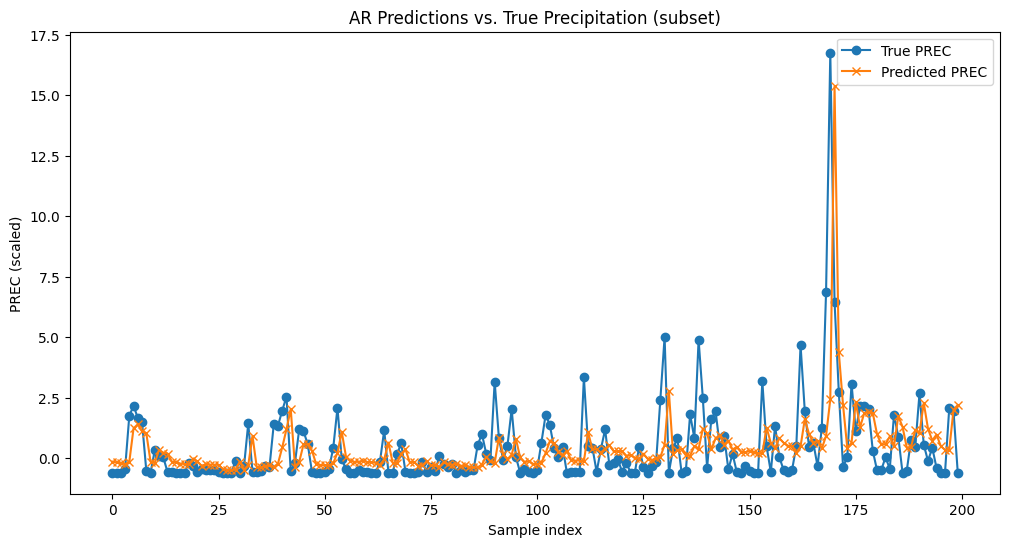

In [20]:
plt.rcParams['figure.figsize'] = (16, 8)
num_samples_to_plot = 200
plt.figure(figsize=(12,6))
plt.plot(y_true[:num_samples_to_plot], label='True PREC', marker='o')
plt.plot(y_hat[:num_samples_to_plot], label='Predicted PREC', marker='x')
plt.title("AR Predictions vs. True Precipitation (subset)")
plt.xlabel("Sample index")
plt.ylabel("PREC (scaled)")
plt.legend()
plt.show()

### Train and evaluate an MA model

In [12]:
with Manager() as manager:
    results_dict = manager.dict()
    processes = []

    for i in range(num_parts):
        p = Process(target=train_model, args=(i, X_parts[i], y_parts[i], results_dict, (0, 0, 1)))
        processes.append(p)
        p.start()

    for p in processes:
        p.join()

    print("Done training")
    results_ma = dict(results_dict)

Part 0: 0/58975
Part 2: 0/58975
Part 4: 0/58975Part 3: 0/58975
Part 1: 0/58975

Part 5: 0/58975Part 6: 0/58975Part 7: 0/58975

Part 8: 0/58975

Part 9: 0/58975
Part 11: 0/58975Part 10: 0/58975
Part 12: 0/58975Part 13: 0/58975


Part 14: 0/58975
Part 15: 0/58975
Part 16: 0/58975Part 17: 0/58975

Part 18: 0/58975Part 19: 0/58975

Part 20: 0/58975Part 21: 0/58975

Part 22: 0/58975
Part 23: 0/58975
Part 15: 1000/58975
Part 0: 1000/58975
Part 6: 1000/58975
Part 13: 1000/58975
Part 1: 1000/58975
Part 2: 1000/58975
Part 20: 1000/58975
Part 4: 1000/58975
Part 17: 1000/58975
Part 23: 1000/58975
Part 10: 1000/58975
Part 11: 1000/58975
Part 22: 1000/58975
Part 18: 1000/58975
Part 3: 1000/58975
Part 5: 1000/58975
Part 12: 1000/58975
Part 16: 1000/58975
Part 14: 1000/58975
Part 21: 1000/58975
Part 8: 1000/58975
Part 19: 1000/58975
Part 9: 1000/58975
Part 7: 1000/58975
Part 15: 2000/58975
Part 13: 2000/58975
Part 10: 2000/58975
Part 17: 2000/58975
Part 1: 2000/58975
Part 0: 2000/58975
Part 12: 2000/

In [21]:
results_ma_list = []
for _, value in results_ma.items():
    results_ma_list.extend(value)

results_ma_list = np.array(results_ma_list)
y_true = results_ma_list[:,0]
y_hat = results_ma_list[:,1]

mse = mean_squared_error(y_true, y_hat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_hat)

print(f"\nTest MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


Test MSE:  0.9640
Test RMSE: 0.9818
Test MAE:  0.6318


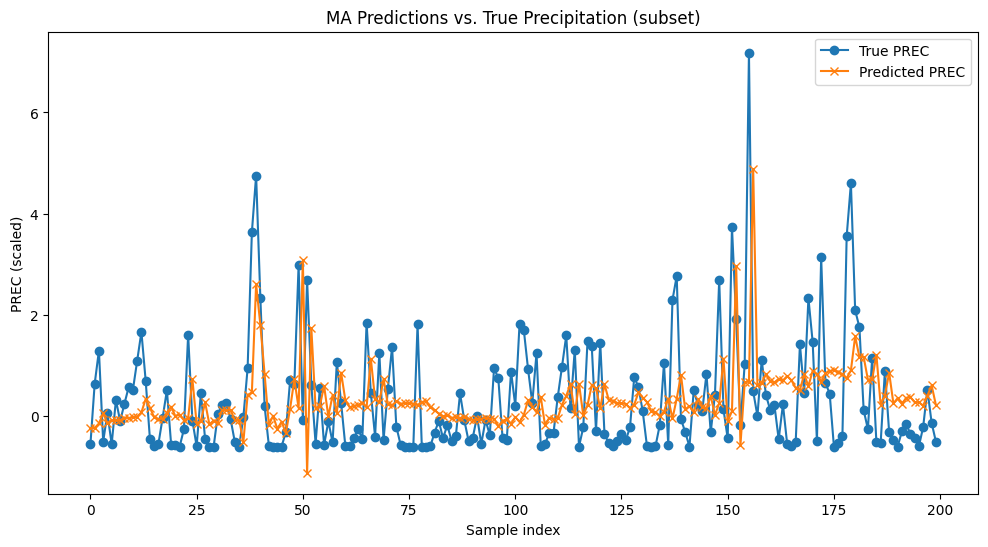

In [23]:
plt.rcParams['figure.figsize'] = (16, 8)
num_samples_to_plot = 200
plt.figure(figsize=(12,6))
plt.plot(y_true[:num_samples_to_plot], label='True PREC', marker='o')
plt.plot(y_hat[:num_samples_to_plot], label='Predicted PREC', marker='x')
plt.title("MA Predictions vs. True Precipitation (subset)")
plt.xlabel("Sample index")
plt.ylabel("PREC (scaled)")
plt.legend()
plt.show()

### Train and evaluate an ARMA model

In [14]:
with Manager() as manager:
    results_dict = manager.dict()
    processes = []

    for i in range(num_parts):
        p = Process(target=train_model, args=(i, X_parts[i], y_parts[i], results_dict, (1, 0, 1)))
        processes.append(p)
        p.start()

    for p in processes:
        p.join()

    print("Done training")
    results_arma = dict(results_dict)

Part 0: 0/58975
Part 3: 0/58975Part 2: 0/58975Part 5: 0/58975Part 4: 0/58975
Part 1: 0/58975



Part 6: 0/58975
Part 7: 0/58975Part 8: 0/58975

Part 11: 0/58975Part 9: 0/58975

Part 10: 0/58975
Part 14: 0/58975Part 13: 0/58975

Part 15: 0/58975
Part 16: 0/58975Part 17: 0/58975

Part 12: 0/58975
Part 18: 0/58975
Part 22: 0/58975
Part 20: 0/58975
Part 23: 0/58975Part 21: 0/58975

Part 19: 0/58975
Part 1: 1000/58975
Part 20: 1000/58975
Part 16: 1000/58975
Part 13: 1000/58975
Part 10: 1000/58975
Part 15: 1000/58975
Part 0: 1000/58975
Part 17: 1000/58975
Part 23: 1000/58975
Part 22: 1000/58975
Part 11: 1000/58975
Part 4: 1000/58975
Part 12: 1000/58975
Part 2: 1000/58975
Part 9: 1000/58975
Part 14: 1000/58975
Part 19: 1000/58975
Part 6: 1000/58975
Part 3: 1000/58975
Part 5: 1000/58975
Part 7: 1000/58975
Part 18: 1000/58975
Part 21: 1000/58975
Part 8: 1000/58975
Part 0: 2000/58975
Part 1: 2000/58975
Part 16: 2000/58975
Part 13: 2000/58975
Part 9: 2000/58975
Part 20: 2000/58975
Part 15: 2000/5

In [24]:
results_arma_list = []
for _, value in results_arma.items():
    results_arma_list.extend(value)

results_arma_list = np.array(results_arma_list)
y_true = results_arma_list[:,0]
y_hat = results_arma_list[:,1]

mse = mean_squared_error(y_true, y_hat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_hat)

print(f"\nTest MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


Test MSE:  1.0252
Test RMSE: 1.0125
Test MAE:  0.6435


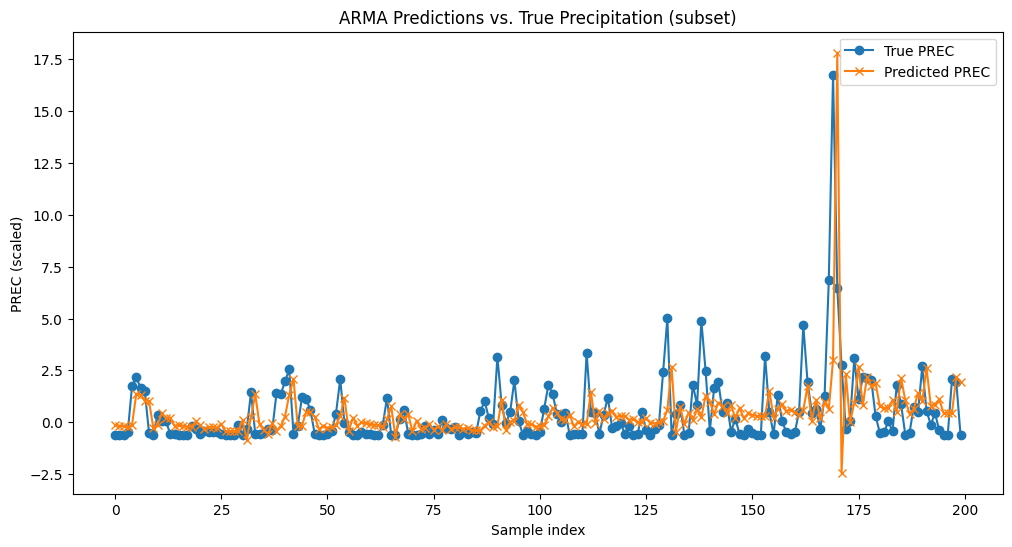

In [25]:
plt.rcParams['figure.figsize'] = (16, 8)
num_samples_to_plot = 200
plt.figure(figsize=(12,6))
plt.plot(y_true[:num_samples_to_plot], label='True PREC', marker='o')
plt.plot(y_hat[:num_samples_to_plot], label='Predicted PREC', marker='x')
plt.title("ARMA Predictions vs. True Precipitation (subset)")
plt.xlabel("Sample index")
plt.ylabel("PREC (scaled)")
plt.legend()
plt.show()